# <center>제5고지 DeZero의 도전</center>

# 52단계 GPU 지원

딥러능에서 하는 계산은 '행렬의 곱'이 대부분이며,  
이는 병렬로 계산할 수 있고, 병렬 계산은 CPU보다 GPU가 더 뛰어남  
  
쿠파이는 GPU를 활용하여 병렬 계산을 해주는 라이브러리이며,  
넘파이와 API가 거의 같아 넘파이 지식을 쿠파이에서도 활용할 수 있음

~~~python
import cupy as cp

x = cp.arange(6).reshape(2,3)
print(x)

y = x.sum(axis=1)
print(y)
~~~

넘파이에서 쿠파이로 변환할 때는 cp.asarray 함수,  
쿠파이에서 넘파이로 변환할 때는 cp.asnumpy 함수를 이용  
  
이 변환 과정에서 데이터가 메인 메모리에서 GPU 메모리로(또는 반대로) 전송되는데,  
실무 딥러닝에서는 다량의 데이터를 다루므로 이 전송 과정이 병목으로 작용할 수 있어  
데이터 전송 횟수를 최소로 억제하게끔 코딩하는 것이 좋음  
  
~~~python
import numpy as np
import cupy as cp

# 넘파이 -> 쿠파이
n = np.array([1,2,3])
c = cp.asarray(n)
assert type(c) == cp.ndarray

# 쿠파이 -> 넘파이
c = cp.array([1,2,3])
n = cp.asnumpy(c)
assert type(n) == np.ndarray
~~~  
  
cp.get_array_module 함수는 주어진 데이터에 적합한 모듈을 돌려줌  
  
데이터가 넘파이 배열인지 쿠파이 배열인지 모르더라도 올바른 모듈을 가져올 수 있으므로 쿠파이/넘파이 모두에 대응하는 코드를 작성할 수 있음  
  
~~~python
# x가 넘파이 배열인 경우
x = np.array([1,2,3])
xp = cp.get_array_module(x)
assert xp == np

# x가 쿠파이 배열인 경우
x = cp.array([1,2,3])
xp = cp.get_array_module(x)
assert xp == cp
~~~  
  


dezero/cuda.py 추가

In [ ]:
import numpy as np
gpu_enable = True
try:
    import cupy as cp
    cupy = cp
except ImportError:
    gpu_enable = False
    
from dezero import Variable

In [ ]:
def get_array_module(x):
    if isinstance(x, Variable):
        x = x.data
        
    if not gpu_enable:
        return np
    xp = cp.get_array_module(x)
    return xp

def as_numpy(x):
    if isinstance(x, Variable):
        x = x.data
    if np.isscalar(x):
        return np.array(x)
    elif isinstance(x, np.ndarray):
        return x
    return cp.asnumpy(x)

def as_cupy(x):
    if isinstance(x, Variable):
        x = x.data
        
    if not gpu_enable:
        raise Exception('쿠파이(CuPy)를 로드할 수 없습니다. 쿠파이를 설치해주세요!')
    return cp.asarray(x)

Variable 클래스의 \_\_init__ 메서드와 backward 메서드 수정  
  
~~~python
...
try:
    import cupy
    array_types = (np.ndarray, cupy.ndarray)
except ImportError:
    array_types = (np.ndarray)
        
class Variable:
    def __init__(self, data, name=None):
        if data is not None:
            if not isinstance(data, array_types):
                raise TypeError('{} is not supported'.format(type(data)))
                
        ...
        
    def backward(self, retain_grad=False, create_graph=False):
        if self.grad is None:
            xp = dezero.cuda.get_array_module(self.data)
            self.grad = Variable(xp.ones_like(self.data))
        ...
~~~        

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Variable 클래스 인스턴스 변수 data에 보관한 넘파이 다차원 배열을 GPU 혹은 CPU로 전송해주는 메서드 추가  
  
~~~python
class Variable:
    ...
    
    def to_cpu(self):
        if self.data is not None:
            self.data = dezero.cuda.as_numpy(self.data)
            
    def to_gpu(self):
        if self.data is not None:
            self.data = dezero.cuda.as_cupy(self.data)
~~~  
  
Layer 클래스에도 매개변수를 CPU 또는 GPU에 전송하는 메서드 추가

~~~python
class Layer:
    ...
    
    def to_cpu(self):
        for param in self.params():
            parma.to_cpu()
            
    def to_gpu(self):
        for param in self.params():
            param.to_gpu()
~~~  
  
데이터셋을 미니배치로 뽑는 역할을 수행하는 DataLoader 클래스를 gpu 플래그를 확인하여 쿠파이와 넘파이 중 알맞은 다차원 배열을 만들어주도록 다음과 같이 수정  
  
~~~python
import numpy as np
from dezero import cuda

class DataLoader:
    def __init__(self, dataset, batch_size, shuffle=True, gpu=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.data_size = len(dataset)
        self.max_iter = math.ceil(self.data_size / batch_size)
        self.gpu = gpu
        
        self.reset()
        
    def __next__(self):
        ...
        
        xp = cuda.cupy if self.gpu else np
        x = xp.array([example[0] for example in batch])
        t = xp.array([example[1] for example in batch])
        
        self.iteration += 1
        
        return x, t
    
    def to_cpu(self):
        self.gpu = False
        
    def to_gpu(self):
        self.gpu = True
~~~

함수 추가 구현  
  
예를 들어 Sin 클래스의 경우,  
인수 x가 넘파이면 np.sin을 사용하고, 쿠파이면 cp.sin을 사용하도록 다음과 같이 수정  
  
~~~python
from dezero import cuda

class Sin(Function):
    def forward(self, x):
        xp = cuda.get_array_module(x) # 추가
        y = xp.sin(x) # 수정
        return y
    
    def backward(self, gy):
        x, = self.inputs
        gx = gy * cos(x)
        return gx
~~~
  
dezero/functions.py, dezero/optimizers.py, dezero/layers.py에서 np.로 시작하는 코드들을 위와 같이 수정

__사칙연산 코드 수정__  
  
as_array 함수에 새로운 인수 array_module 추가 및 사칙연산 함수에 이를 적용  
  
~~~python
def as_array(x, array_module=np):
    if np.isscalar(x):
        return array_module.array(x)
    return x

def add(x0, x1):
    x1 = as_array(x1, dezero.cuda.get_array_module(x0.data))
    return Add()(x0, x1)

def mul(x0, x1):
    x1 = as_array(x1, dezero.cuda.get_array_module(x0.data))
    return Mul()(x0, x1)

...
# sub, rsub, div, rdiv도 똑같이 수정
~~~

__GPU로 MNIST 학습__

In [2]:
pip install dezero

In [ ]:
# colab에서 GPU로 학습

import time
import dezero
import dezero.functions as F
from dezero import optimizers
from dezero import DataLoader
from dezero.models import MLP

max_epoch = 5
batch_size = 100

train_set= dezero.datasets.MNIST(train=True)
train_loader = DataLoader(train_set, batch_size)
model = MLP((1000, 10))
optimizer = optimizers.SGD().setup(model)

# GPU 모드
if dezero.cuda.gpu_enable:
    train_loader.to_gpu()
    model.to_gpu()
    
for epoch in range(max_epoch):
    start = time.time()
    sum_loss = 0
    
    for x, t in train_loader:
        y = model(x)
        loss = F.softmax_cross_entropy(y, t)
        model.cleargrads()
        loss.backward()
        optimizer.update()
        sum_loss += float(loss.data) * len(t)
        
    elapsed_time = time.time() - start
    print('epoch: {}, loss: {:.4f}, time: {:.4f}[sec]'.format(
    epoch + 1, sum_loss / len(train_set), elapsed_time))

epoch: 1, loss: 1.9102, time: 3.5392[sec]
epoch: 2, loss: 1.2792, time: 3.4602[sec]
epoch: 3, loss: 0.9216, time: 3.4154[sec]
epoch: 4, loss: 0.7381, time: 3.9952[sec]
epoch: 5, loss: 0.6341, time: 4.2255[sec]


In [3]:
# CPU로 학습
import time
import dezero
import dezero.functions as F
from dezero import optimizers
from dezero import DataLoader
from dezero.models import MLP

max_epoch = 5
batch_size = 100

train_set= dezero.datasets.MNIST(train=True)
train_loader = DataLoader(train_set, batch_size)
model = MLP((1000, 10))
optimizer = optimizers.SGD().setup(model)

# GPU 모드
if dezero.cuda.gpu_enable:
    train_loader.to_gpu()
    model.to_gpu()
    
for epoch in range(max_epoch):
    start = time.time()
    sum_loss = 0
    
    for x, t in train_loader:
        y = model(x)
        loss = F.softmax_cross_entropy(y, t)
        model.cleargrads()
        loss.backward()
        optimizer.update()
        sum_loss += float(loss.data) * len(t)
        
    elapsed_time = time.time() - start
    print('epoch: {}, loss: {:.4f}, time: {:.4f}[sec]'.format(
    epoch + 1, sum_loss / len(train_set), elapsed_time))

Downloading: train-images-idx3-ubyte.gz
[##############################] 100.00% Done
Downloading: train-labels-idx1-ubyte.gz
[##############################] 100.00% Done
epoch: 1, loss: 1.8981, time: 15.7417[sec]
epoch: 2, loss: 1.2625, time: 11.6274[sec]
epoch: 3, loss: 0.9103, time: 13.4848[sec]
epoch: 4, loss: 0.7304, time: 15.2637[sec]
epoch: 5, loss: 0.6286, time: 11.6959[sec]


# 53단계 모델 저장 및 읽어오기

np.save 함수 : ndarray 인스턴스를 외부 파일로 저장
np.load 함수 : 저장되어 있는 데이터를 읽어옴

In [5]:
import numpy as np
x = np.array([1,2,3])
np.save('test.npy', x)

x = np.load('test.npy') # 확장자 npy
print(x)

[1 2 3]


여러 개의 ndarray 인스턴스를 저장하고 읽어오기

In [6]:
x1 = np.array([1,2,3])
x2 = np.array([4,5,6])

np.savez('test.npz', x1=x1, x2=x2)

arrays = np.load('test.npz')
x1 = arrays['x1']
x2 = arrays['x2']
print(x1)
print(x2)

[1 2 3]
[4 5 6]


앞의 코드를 딕셔너리를 사용해 수정

In [8]:
x1 = np.array([1,2,3])
x2 = np.array([4,5,6])
data = {'x1':x1, 'x2':x2}

np.savez('test.npz', **data) # 별표 두 개를 붙여주면 딕셔너리가 자동으로 전개되어 전달됨

arrays = np.load('test.npz')
x1 = arrays['x1']
x2 = arrays['x2']
print(x1)
print(x2)

[1 2 3]
[4 5 6]


np.savez_comporessed 함수는 np.savez에 내용 압축 기능을 추가한 함수  
위 함수들을 이용하여 DeZero 매개변수를 외부 파일로 저장하는 기능을 추가  
  
Layer 클래스 안의 Parameter를 '평탄화'하여 꺼냄  
평탄화 작업을 위해 우선 Layer 클래스에 \_flatten_params 메서드를 추가  
  
~~~python
class Layer:
    ...
    
    def _flatten_params(self, params_dict, parent_key=''):
        for name in self._params:
            obj = self.__dict__[name]
            key = parent_key + '/' + name if parent_key else name
            
            if isinstance(obj, Layer):
                obj._flatten_params(params_dict, key)
            else:
                params_dict[key] = obj
~~~
  
메서드가 재귀적으로 호출되므로 모든 Parameter를 한 줄로 평탄화시켜 꺼낼 수 있음

ex)  
  
<img src='./img/5/ex1.png' width=300>

In [3]:
from dezero import Parameter
from dezero import Layer
import numpy as np

layer = Layer()

l1 = Layer()
l1.p1 = Parameter(np.array(1))

layer.l1 = l1
layer.p2 = Parameter(np.array(2))
layer.p3 = Parameter(np.array(3))

In [4]:
params_dict = {}
layer._flatten_params(params_dict)
print(params_dict)

{'p2': variable(2), 'p3': variable(3), 'l1/p1': variable(1)}


Layer 클래스에 save_weights와 load_weights 메서드 추가  
  
~~~python
import os

class Layer:
    ...
    
    def save_weights(self, path):
        self.to_cpu() # 데이터는 넘파이 ndarray
        
        params_dict = {}
        self._flatten_params(params_dict)
        array_dict = {key: param.data for key, param in params_dict.items()
                     if param is not None}
        
        try:
            np.savez_compressed(path, **array_dict)
        except (Exception, KeyboardInterrupt) as e: # 저장 도중 인터럽트 발생하면 파일이 삭제됨
            if os.path.exists(path):
                os.remove(path)
            raise
            
    def load_weights(self, path):
        npz = np.load(path)
        params_dict = {}
        self._flatten_params(params_dict)
        for key, param in params_dict.items():
            param.data = npz[key]
~~~

MNIST 학습을 예로 매개변수 저장과 읽기 기능 시험

In [7]:
import os
import dezero
import dezero.functions as F
from dezero import optimizers
from dezero import DataLoader
from dezero.models import MLP

max_epoch = 3
batch_size = 100

train_set = dezero.datasets.MNIST(train=True)
train_loader = DataLoader(train_set, batch_size)
model = MLP((1000, 10))
optimizer = optimizers.SGD().setup(model)

# 매개변수 읽기
if os.path.exists('my_mlp.npz'):
    model.load_weights('my_mlp.npz')
    
for epoch in range(max_epoch):
    sum_loss = 0
    
    for x, t in train_loader:
        y = model(x)
        loss = F.softmax_cross_entropy(y, t)
        model.cleargrads()
        loss.backward()
        optimizer.update()
        sum_loss += float(loss.data) * len(t)
        
    print('epoth : {}, loss : {:.4f}'.format(
        epoch + 1, sum_loss / len(train_set)))
    
# 매개변수 저장하기
model.save_weights('my_mlp.npz')

epoth : 1, loss : 1.8980
epoth : 2, loss : 1.2702
epoth : 3, loss : 0.9143


# 54단계 드롭아웃과 테스트 모드

과대적합이 일어나는 주요 원인
- 훈련 데이터가 적음
- 모델의 표현력이 지나치게 높음  
  
첫 번째 원인의 경우 데이터 확장(data augmentation)을 이용,  
두 번째 원인의 경우 가중치 감소(Weight decay), 드롭아웃(Dropout), 배치 정규호(Batch Normalization) 등을 이용하여 보완할 수 있음  
  
이 중 드롭아웃은 간단하면서도 효과적이어서 실무에 많이 사용되고 있음  
드롭아웃이란 뉴런을 임의로 삭제(비활성화)하면서 학습하는 방법을 말함  
  
<img src='./img/5/dropout_1.png' width=500>  
  
ex) 드롭아웃 학습 시 처리 예시  
  
10개의 뉴런으로 이루어진 층이 있고,  
그 다음 층에서 드롭아웃 계층을 사용하여 60%의 뉴런을 무작위로 삭제하는 경우  
코드는 다음처럼 작성할 수 있음

In [8]:
import numpy as np

dropout_ratio = 0.6
x = np.ones(10)

mask = np.random.rand(10) > dropout_ratio # mask는 원소가 True 혹은 False인 배열
y = x * mask # False인 원소에 대응하는 x의 원소를 0으로 설정(삭제)

In [10]:
y

array([0., 0., 1., 0., 0., 1., 0., 1., 1., 0.])

앙상블 학습(Ensemble Learning) : 여러 모델을 개별적으로 학습시킨 후 추론 시 모든 모델의 출력을 평균 내는 방법    
학습 시 뉴런을 임의로 삭제하는 드롭아웃 또한 매번 다른 모델을 학습하고 있다고 해석할 수 있기 때문에  
드롭아웃은 앙상블 학습은 같은 효과를 신경망 하나에서 가상으로 시뮬레이션한다고 간주할 수 있음  
  
드롭아웃에서는 모든 뉴런을 써서 출력을 계산한 후, 학습 시에 살아남은 뉴런의 비율만큼 결과를 약화시켜서 학습 시와 테스트 시의 비율을 일치시켜줘야 함

In [14]:
# 학습 시
mask = np.random.rand(*x.shape) > dropout_ratio
y = x * mask

# 테스트 시
scale = 1 - dropout_ratio # 학습 시에 살아남은 뉴런의 비율
y = x * scale

여기까지가 일반적인 드롭아웃, 다이렉트 드롭아웃(Direct dropout)임

__역 드롭아웃__  
  
다이렉트 드롭아웃은 스케일을 테스트할 때 맞춰준 반면,  
역 드롭아웃은 '학습할 때' 수행함  

In [16]:
# 학습 시
scale = 1 - dropout_ratio
mask = np.random.rand(*x.shape) > dropout_ratio
y = x * mask / scale

# 테스트 시
y = x

위와 같이 테스트 시 아무런 처리도 하지 않기 때문에 테스트 속도가 조금 향상됨  
또한, 역 드롭아웃은 학습할 때 dropout_ratio를 동적으로 변경할 수 있음  

이러한 이점 때문에 많은 딥러닝 프레임워크에서 역 드롭아웃 방식을 채용하고 있음  
DeZero에서도 역 드롭아웃으로 사용

드롭아웃을 사용하려면 학습 / 테스트 단계를 구분해야하므로,  
18단계에서 만든 역전파 비활성 모드 방식을 활용하여 dezero/core.py의 Config 클래스를 다음과 같이 수정  
  
~~~python
class Config:
    enable_backprop = True
    train = True # 추가
    
@contextlib.contextmanager
def using_config(name, value):
    old_value = getattr(Config, name)
    setattr(Config, name, value)
    yield
    setattr(Config, name, old_value)
    
def test_mode(): # 추가
    return using_config('train', False)
~~~

__드롭아웃 구현__  
  
dezero/functions.py 에 추가  
  
~~~python
def dropout(x, dropout_ratio=0.5):
    x = as_variable(x)
    
    if dezero.Config.train:
        xp = cuda.get_array_module(x)
        mask = xp.random.rand(*x.shape) > dropout_ratio
        scale = xp.array(1.0 - dropout_ratio).astype(x.dtype)
        y = x * mask / scale
        return y
    else:
        return x
~~~

In [17]:
import numpy as np
from dezero import test_mode
import dezero.functions as F

x = np.ones(5)
print(x)

# 학습 시
y = F.dropout(x)
print(y)

# 테스트 시
with test_mode():
    y = F.dropout(x)
    print(y)

[1. 1. 1. 1. 1.]
variable([0. 0. 2. 2. 0.])
variable([1. 1. 1. 1. 1.])


# 55단계 CNN 메커니즘(1)

__CNN(Convolutional Neural Network), 합성곱 신경망__  
  
<img src='./img/5/cnn_1.png' width=700>  
CNN 신경망의 예  
  
위 그림에서 볼 수 있듯이 CNN에는 Conv 계층과 Pool 계층이 새로 추가됨  
또한 일반적인 CNN에서 흔히 볼 수 있는 구조는  
'Conv $\rightarrow$ ReLU $\rightarrow$ Pool(생략 가능)' 순서로 연결되고  
출력에 가까워지면 'Linear $\rightarrow$ ReLU' 조합이 사용됨  

__합성곱 연산__  
  
<img src='./img/5/cnn_2.png' width=500>  
  
합성곱 층(Conv)에서는 합성곱 영ㄴ산을 수행함  
이는 이미지 처리에서 말하는 '필터 연산'에 해당됨  
    
<img src='./img/5/cnn_3.png' width=800>  
  
합성곱 연산은 위의 그림과 같이 입력 데이터에 대해 필터 윈도(window)를 일정 간격으로 이동시키면서 적용함  
필터와 입력의 해당 원소를 곱하고 총합을 구한 결과를 해당 위치에 저장함  
필터(filter)는 문헌에 따라 커널(kernel)이라고도 쓰임

<img src='./img/5/cnn_4.png' width=500>  
  
편향까지 포함시키면 위의 그림과 같음  
편향은 필터링 후에 더해짐  
  
__패딩__  
  
<img src='./img/5/cnn_5.png' width=500>  
  
합성곱층의 주요 전처리 전에 입력 데이터 주위에 고정값(가령 0 등)을 채워주는 처리를 패딩(padding)이라고 함  
위의 그림은 패딩을 1로 설정한 것이며, 2나 3 등 임의의 정수로 설정할 수 있고,  
세로 방향 패딩과 가로 방향 패딩을 서로 다르게 설정할 수도 있음  
  
합성곱 연산을 거칠때마다 공간이 축소되다 보면 어느 순간 더 이상의 합성곱 연산을 할 수 없게 됨  
이런 사태를 피하기 위해(출력 크기를 조정하기 위해) 패딩을 이용함  
  
__스트라이드__  
  
<img src='./img/5/cnn_6.png' width=500>  
  
필터를 적용하는 위치의 간격을 스트라이드(stride, 보폭을 뜻함)라고 함  
스트라이드도 세로 방향과 가로 방향 값을 다르게 설정할 수 있음


__출력 크기 계산__  
  
입력 데이터와 커널(필터)의 크기가 주어지면 출력 크기가 결정됨  
다음과 같이 계산할 수 있음  

In [18]:
def get_conv_outsize(input_size, kernel_size, stride, pad):
    return (input_size + pad*2 - kernel_size) // stride + 1

In [19]:
H, W = 4, 4 # 입력 형상
KH, KW = 3, 3 # 커널 형상
SH, SW = 1, 1 # 스트라이드(세로 방향 스트라이드와 가로 방향 스트라이드)
PH, PW = 1, 1 # 패딩(세로 방향 패딩과 가로 방향 패딩

OH = get_conv_outsize(H, KH, SH, PH)
OW = get_conv_outsize(W, KW, SW, PW)
print(OH, OW)

4 4


# 56단계 CNN 메커니즘(2)

이미지는 가로/세로 방향뿐 아니라 RGB처럼 '채널 방향'으로도 데이터가 쌓여 있기 때문에 3차원 데이터(3차원 텐서)를 다뤄야 함  
<img src='./img/5/cnn_7.png' width=500>  
  
채널이 3개인 데이터로 수행한 합성곱 연산은 위 그림과 같음  
입력 데이터와 필터의 '채널' 수를 똑같이 맞춰줘야 하며,  
필터의 가로, 세로 크기는 원하는 숫자로 설정할 수 있음  
  
<img src='./img/5/cnn_8.png' width=500>  
  
3차원 텐서에 대한 합성곱 연산을 직육면체 블록으로 표현  
아래는 입력 데이터, 필터, 출력 데이터의 형상  
출력은 '특징 맵(feature map)'이라고 불리며,  
위 예시에서는 특징 맵이 한 장만 출력됐음  
  
<img src='./img/5/cnn_9.png' width=500>  
  
만약 특징 맵을 여러 장 출력하려면, 다수의 필터(가중치)를 사용하면 됨  
위 그림과 같이 OC개의 필터를 개별적으로 적용  
  
<img src='./img/5/cnn_10.png' width=500>  
  
편향은 채널당 하나의 값만 갖으며, 편향을 추가하면 위 그림과 같음  
  
<img src='./img/5/cnn_11.png' width=500>  
  
미니배치 처리를 위해서는 각 층을 흐르는 데이터를 '4차원 텐서'로 취급  
데이터 형상 맨 앞에 배치를 위한 차원 추가  
미니배치 처리에서는 4차원 텐서의 샘플 데이터 각각에 대해 독립적으로 똑같은 합성곱 연산을 수행함  
  
<img src='./img/5/cnn_12.png' width=500>  
  
풀링은 가로, 세로 공간을 작게 만드는 연산으로,  
위 그림 예시는 2 $\times$ 2 Max 풀링을 스트라이드 2로 수행하는 경우의 처리 절차를 보여줌  
Max 풀링(최대 풀링)은 최댓값을 취하는 연산이며, '2 $\times$ 2'는 대상 영역의 크기를 나타냄  
Max 풀링 외에 Average 풀링(평균 풀링)도 잇으나, 이미지 인식 분야에서는 주로 Max 풀링을 사용함  
  
풀링층의 주요 특징은 다음과 같음  
- 학습하는 매개변수가 없다
- 채널 수가 변하지 않는다
- 미세한 위치 변화에 영향을 덜 받는다


# 57단계 conv2d 함수와 pooling 함수

__합성곱층의 구현 흐름__  
  
<img src='./img/5/cnn_13.png' width=500>  
  
im2col(image to column의 약자)함수는 입력 데이터를 한 줄로 '전개'하는 함수로,  
합성곱 연산 중 커널 계산에 편리하도록 배치 수를 포함한 4차원 텐서인 입력 데이터를 펴줌  
  
위 그림과 같이 커널을 적용할 영역을 꺼낸 후 한 줄로 형상을 바꿔 최종적으로 행렬(2차원 텐서)로 변환함  
  
<img src='./img/5/cnn_14.png' width=500>  
  
im2col로 입력 데이터를 전개한 후에는 합성곱 층 커널(필터)을 한 줄로 전개한 다음,  
위 그림처럼 두 행렬을 곱하며,  
행렬(2차원 텐서)이 출력됨  
이 출력을 배치 수를 포함한 4차원 텐서로 다시 변환해줌  
  

~~~python
class Im2col(Function):
    def __init__(self, kernel_size, stride, pad, to_matrix):
        super().__init__()
        self.input_shape = None
        self.kernel_size = kernel_size
        self.stride = stride
        self.pad = pad
        self.to_matrix = to_matrix

    def forward(self, x):
        self.input_shape = x.shape
        y = im2col_array(x, self.kernel_size, self.stride, self.pad,
                         self.to_matrix)
        return y

    def backward(self, gy):
        gx = col2im(gy, self.input_shape, self.kernel_size, self.stride,
                    self.pad, self.to_matrix)
        return gx
    
def im2col(x, kernel_size, stride=1, pad=0, to_matrix=True):
    y = Im2col(kernel_size, stride, pad, to_matrix)(x)
    return y
~~~

In [21]:
import numpy as np
import dezero.functions as F

x1 = np.random.rand(1,3,7,7) # 배치크기 1, 채널 수 3, 높이 7, 너비 7
col1 = F.im2col(x1, kernel_size=5, stride=1, pad=0, to_matrix=True)
print(col1.shape)

x2 = np.random.rand(10,3,7,7)
kernel_size = (5,5)
stride = (1,1)
pad = (0,0)
col2 = F.im2col(x2, kernel_size, stride, pad, to_matrix=True)
print(col2.shape)

(9, 75)
(90, 75)


im2col 함수의 인수 중 to_matrix는 True면 커널을 적용할 영역을 추출한 후 '행렬'로 형상을 변환함(행렬 곱으로 계산하기 위함)  

__conv2d 함수 구현__  
  

~~~python
from dezero.utils import pair, get_conv_outsize

def conv2d_simple(x, W, b=None, stride=1, pad=0):
    x, W = as_variable(x), as_variable(W)
    
    Weight = W # Width의 'W'와 헷갈리지 않기 위해
    N, C, H, W = x.shape
    OC, C, KH, KW = Weight.shape
    SH, SW = pair(stride)
    PH, PW = pair(pad)
    OH = get_conv_outsize(H, KH, SH, PH)
    OW = get_conv_outsize(W, KW, SW, PW)
    
    col = im2col(x, (KH, KW), stride, pad, to_matrix=True) # 1
    Weight = Weight.reshape(OC, -1).transpose() # 2
    t = linear(col, Weight, b) # 3
    y = t.reshape(N, OH, OW, OC).transpose(0,3,1,2) # 4
    return y
~~~

\# 1 : 입력 데이터를 im2col로 전개  
\# 2 : 커널 Weight를 한 줄로 펼쳐 재정렬  
\# 3 : 행렬 곱 계산. 선형 변환인 linear 함수를 사용하여 편향까지 포함한 계산을 수행  
\# 4 : 출력 크기를 적절한 형상으로 바꾼 후 축 순서를 바꿔줌

\* conv2d 함수에서 사용한 pair(x) 편의 함수는 인수 x가 int라면 (x,x) 형태의 튜플로 변환해 반환하고, x가 원소 2개짜리 튜플이면 그대로 돌려줌  
  
~~~python
def pair(x):
    if isinstance(x, int):
        return (x, x)
    elif isinstance(x, tuple):
        assert len(x) == 2
        return x
    else:
        raise ValueError
~~~  
  


In [23]:
from dezero import Variable

N, C, H, W = 1, 5, 15, 15
OC, (KH, KW) = 8, (3, 3)

x = Variable(np.random.randn(N, C, H, W))
W = np.random.randn(OC, C, KH, KW)
y = F.conv2d_simple(x, W, b=None, stride=1, pad=1)
y.backward()

print(y.shape)
print(x.grad.shape) # 역전파도 문제없이 작동함

(1, 8, 15, 15)
(1, 5, 15, 15)


__Conv2d 계층 구현__  
  
~~~python
class Conv2d(Layer):
    def __init__(self, out_channels, kernel_size, stride=1, 
                 pad=0, nobias=False, dtype=np.float32, in_channels=None):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.pad = pad
        self.dtype = dtype
        
        self.W = Parameter(None, name='W')
        if in_channels is not None: 
            self._init_W()
            
        if nobias:
            self.b = None
        else:
            self.b = Parameter(np.zeros(out_channels, dtype=dtype), name='b')
            
    def _init_W(self, xp=np):
        C, OC = self.in_channels, self.out_channels
        KH, KW = pair(self.kernel_size)
        scale = np.sqrt(1 / (C * KH * KW))
        W_data = xp.random.randn(OC, C, KH, KW).astype(self.dtype) * scale
        self.W.data = W_data
        
    def forward(self, x):
        if self.W.data is None: # in_channel이 None이면 x의 형상으로부터 값을 얻음
            self.in_channels = x.shape[1]
            xp = cuda.get_array_module(x)
            self._init_W(xp)
            
        y = F.conv2d_simple(x, self.W, self.b, self.stride, self.pad)
        return y
~~~

__pooling 함수 구현__  
  
<img src='./img/5/cnn_15.png' width=700>  
  
풀링의 적용 영역은 채널마다 독립적으로 전개함  
  
<img src='./img/5/cnn_16.png' width=700>  

전개된 행렬의 각 행별로 최댓값을 구해 적절한 형상으로 바꿔줌  
  
~~~python
def pooling_simple(x, kernel_size, stride=1, pad=0):
    x = as_variable(x)
    
    N, C, H, W = x.shape
    KH, KW = pair(kernel_size)
    PH, PW = pair(pad)
    SH, SW = pair(stride)
    OH = get_conv_outsize(H, KH, SH, PH)
    HW = get_conv_outsize(W, KW, SW, PW)
    
    col = im2col(x, kernel_size, stride, pad, to_matrix=True) # 전개
    col = col.reshape(-1, KH*KW)
    y = col.max(axis=1) # 최댓값
    y = y.reshape(N, OH, OW, C).transpose(0,3,1,2) # 형상 변환
    return y
~~~

# 58단계 대표적인 CNN(VGG16)

__VGG16 구현__  
  
<img src='./img/5/vgg_1.png' width=700>  
  
VGG는 2014년 ILSVRC 대회에서 준우승한 모델이며,  
구조는 위 그림과 같음  
  
- 3 $\times$ 3 합성곱층 사용(패딩은 1 $\times$ 1), 출력 채널 수는 64
- 합성곱층의 채널 수는 2 $\times$ 2로 풀링하여 2배씩 증가(64 $\rightarrow$ 128 $\rightarrow$ 256 $\rightarrow$ 512) 
- Linear 4096은 출력 크기가 4096인 완전연결계층을 가리킴
- 완전연결계층에는 드롭아웃 사용
- 활성화 함수로 ReLU 사용

__VGG16 구현__

~~~python
import dezero.functions as F
import dezero.layers as L

class VGG16(Model):
    def __init__(self):
        # 1. 출력 채널 수만큼 지정
        self.cont1_1 = L.Conv2d(64, kernel_size=3, stride=1, pad=1)
        self.cont1_2 = L.Conv2d(64, kernel_size=3, stride=1, pad=1)
        self.cont2_1 = L.Conv2d(128, kernel_size=3, stride=1, pad=1)
        self.cont2_2 = L.Conv2d(128, kernel_size=3, stride=1, pad=1)
        self.cont3_1 = L.Conv2d(256, kernel_size=3, stride=1, pad=1)
        self.cont3_2 = L.Conv2d(256, kernel_size=3, stride=1, pad=1)
        self.cont3_3 = L.Conv2d(256, kernel_size=3, stride=1, pad=1)
        self.cont4_1 = L.Conv2d(512, kernel_size=3, stride=1, pad=1)
        self.cont4_2 = L.Conv2d(512, kernel_size=3, stride=1, pad=1)
        self.cont4_3 = L.Conv2d(512, kernel_size=3, stride=1, pad=1)
        self.cont5_1 = L.Conv2d(512, kernel_size=3, stride=1, pad=1)
        self.cont5_2 = L.Conv2d(512, kernel_size=3, stride=1, pad=1)
        self.cont5_3 = L.Conv2d(512, kernel_size=3, stride=1, pad=1)
        self.fc6 = L.Linear(4096) # 2. 출력 크기만 지정
        self.fc7 = L.Linear(4096)
        self.fc8 = L.Linear(1000)
        
    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = F.pooling(x, 2, 2)
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = F.pooling(x, 2, 2)        
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv3_3(x))
        x = F.pooling(x, 2, 2)        
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv4_3(x))
        x = F.pooling(x, 2, 2)        
        x = F.relu(self.conv5_1(x))
        x = F.relu(self.conv5_2(x))
        x = F.relu(self.conv5_3(x))
        x = F.pooling(x, 2, 2)
        x = F.reshape(x, (x.shape[0], -1)) # 3. 완전연결계층으로 전환하기 위해 데이터 형상 변환(4차원 텐서 -> 2차원 텐서)
        x = F.dropout(F.relu(self.fc6(x)))
        x = F.dropout(F.relu(self.fc7(x)))
        x = self.fc8(x)
        return x
~~~

VGG16은 이미지넷(ImageNet)이라는 큰 데이터셋으로 학습  
학습이 완료된 가중치 데이터가 공개되어 있음  
\* http://www.robots.ox.ac.uk/\~vgg/research/very_deep/ 에 VGG16 모델이 Creative Commons Attribution 라이선스https://creativecommons.org/licenses/by/4.0/ 로 공개되어 있음  
  
지금은 Dezero가 원래 가중치 데이터를 읽을 수 있도록 살짝 수정된 파일을 사용  
  
__VGG16에 학습된 가중치 데이터 읽어오는 기능을 추가__  
  
~~~python
from dezero import utils

class VGG16(Model):
    WEIGHTS_PATH = 'https://github.com/koki0702/dezero-models/' \
    'releases/download/v0.1/vgg16.npz'
    
    def __init__(self, pretrained=False):
        ...
        
        if pretrained:
            weights_path = utils.get_file(VGG16.WEIGHTS_PATH)
            self.load_weights(weights_path)
~~~

Downloading: vgg16.npz
[##############################] 100.00% Done


/var/folders/gs/xm5833ws6f7361xlj18d2j140000gn/T/ipykernel_1199/1226706761.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = np.random.randn(1, 3, 224, 224).astype(np.float) # 더미 데이터


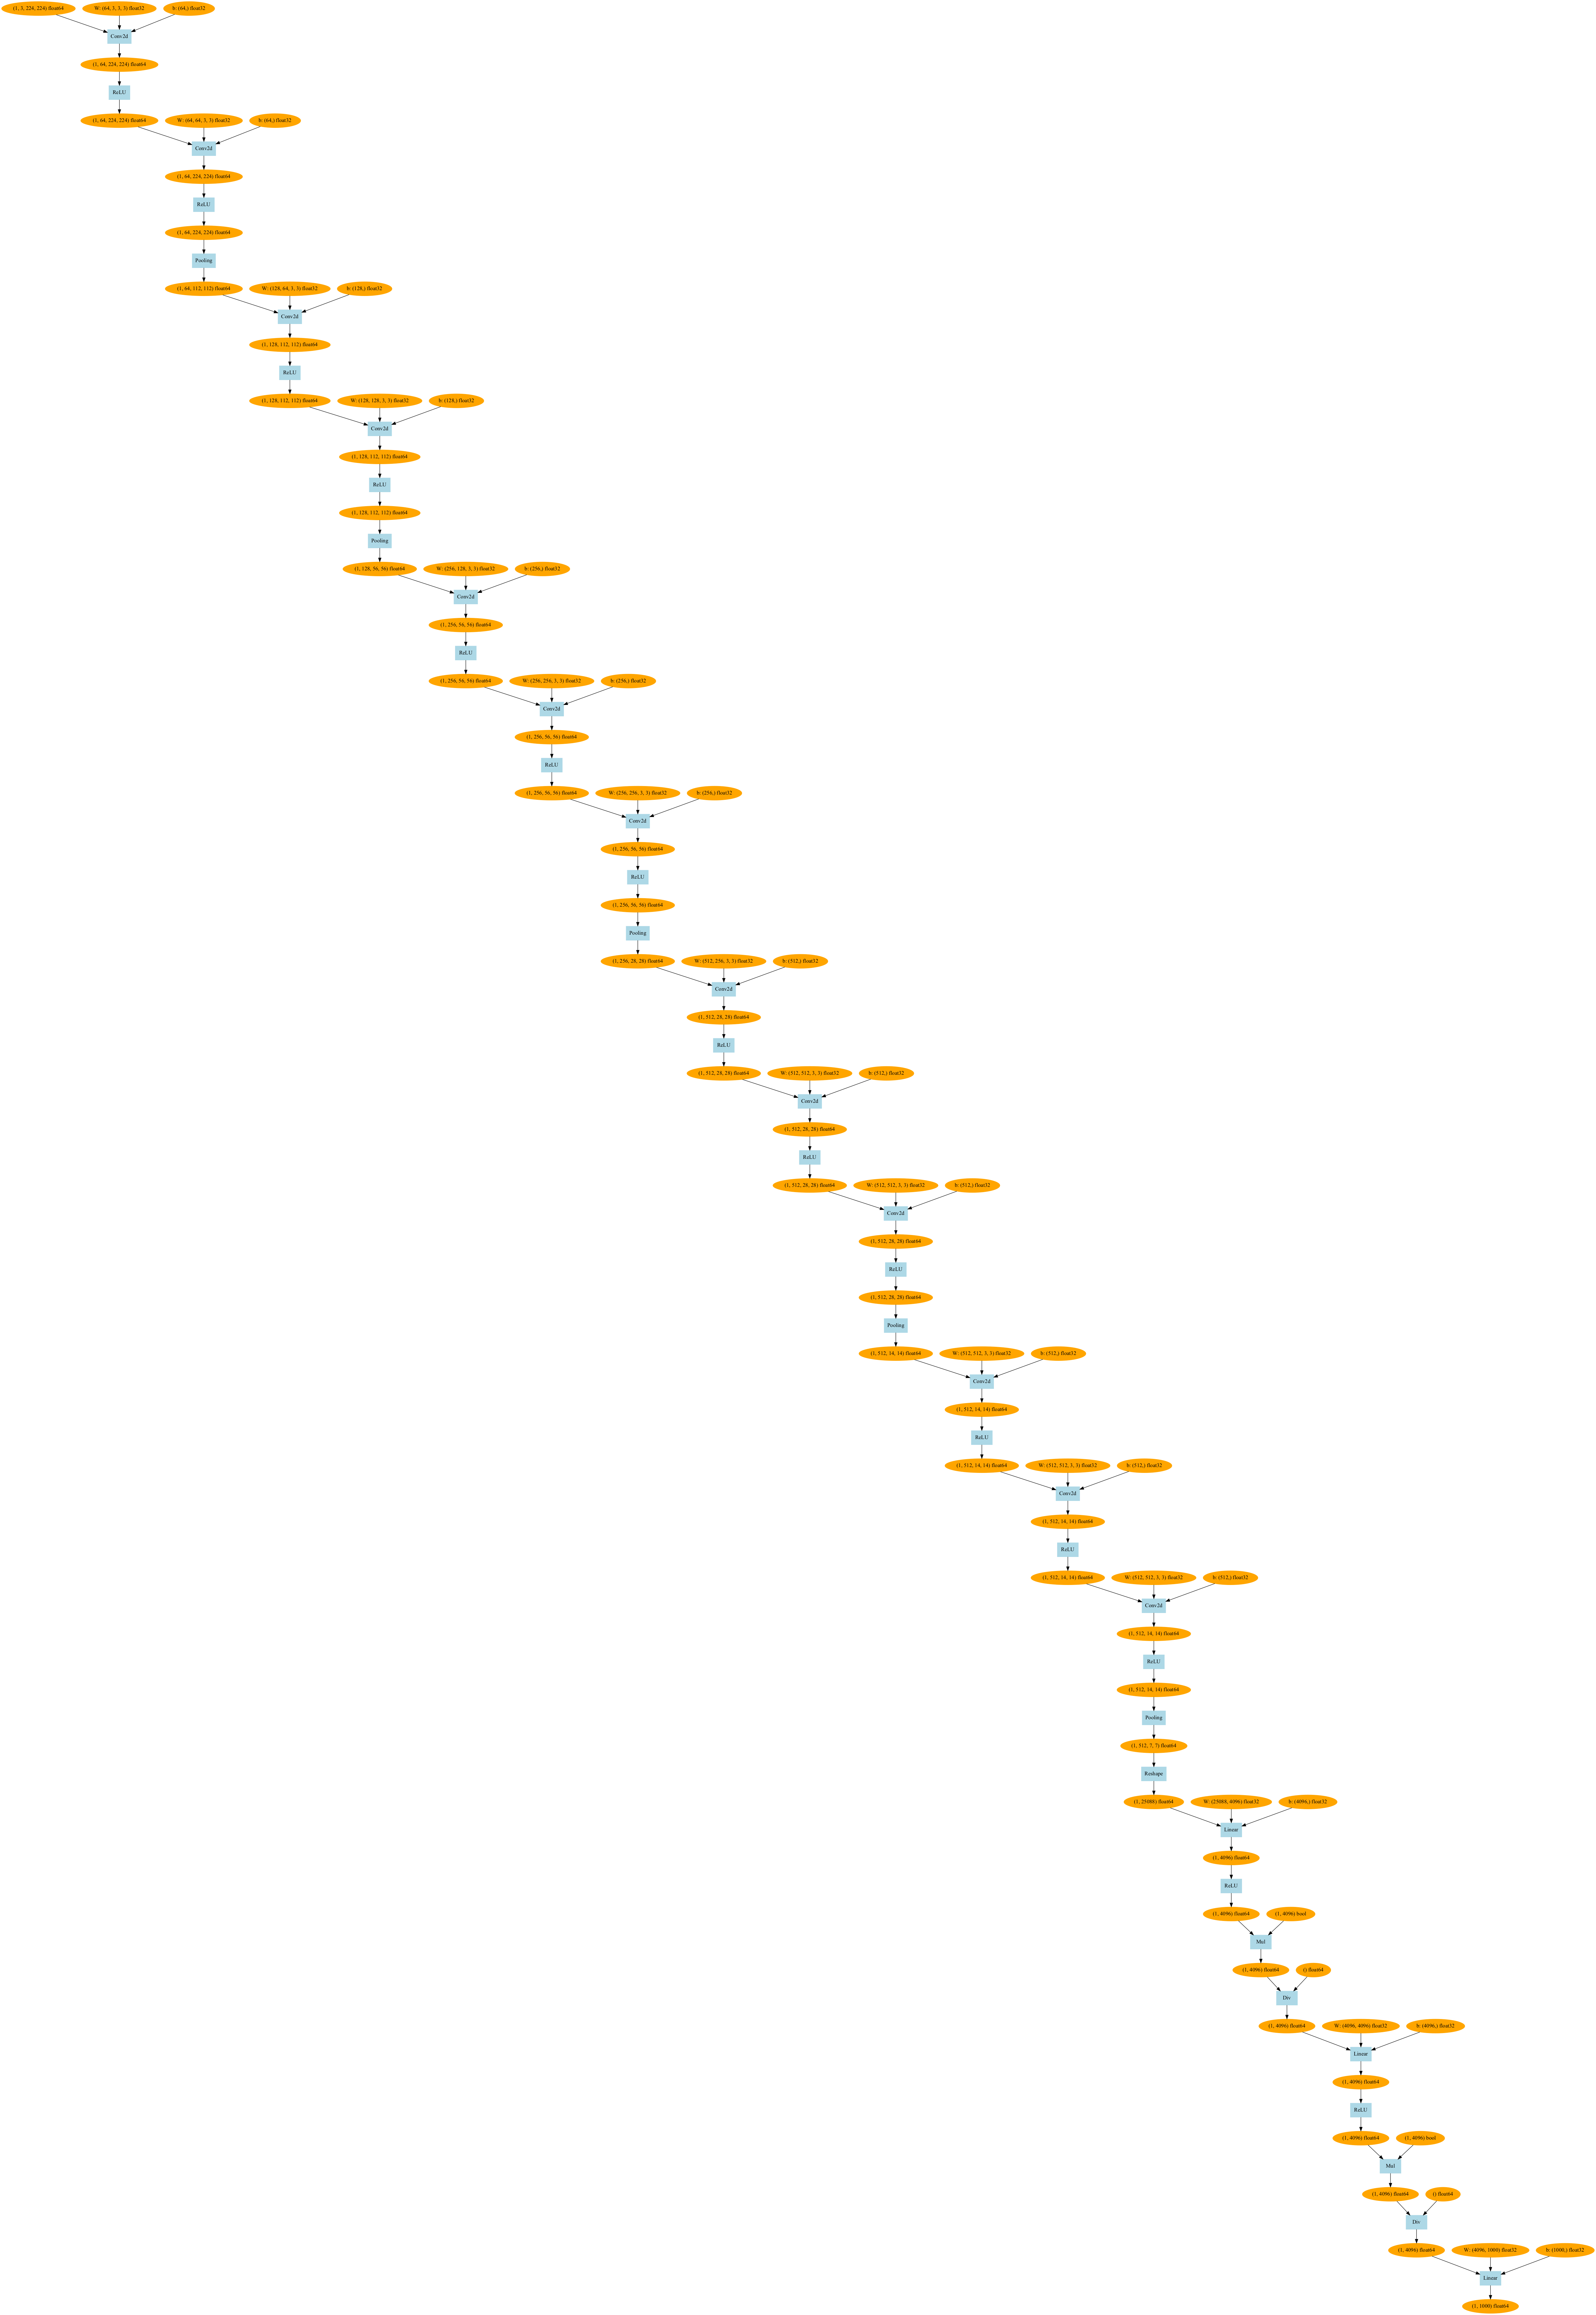

In [1]:
import numpy as np
from dezero.models import VGG16

model = VGG16(pretrained=True)

x = np.random.randn(1, 3, 224, 224).astype(np.float) # 더미 데이터
model.plot(x) # 계산 그래프 시각화

In [3]:
!pip install pillow # PIL(python Image Library) 이미지 처리 라이브러리. 이미지 읽기와 쓰기, 변환 등 다양한 기능 제공

In [4]:
import dezero
from PIL import Image

url = 'https://github.com/WegraLee/deep-learning-from-scratch-3/' \
      'raw/images/zebra.jpg'
img_path = dezero.utils.get_file(url) # 이미지 파일 저장
img = Image.open(img_path)
img.show()

Downloading: zebra.jpg
[##############################] 100.00% Done


위 코드에서 img의 데이터 타입은 PIL.Image  
DeZero는 ndarray 타입 데이터를 취급하므로 적절히 변환해줘야 함  
변환해주는 preprocess 메서드를 VGG16에 추가  
  
~~~python
@staticmethod
def preprocess(image, size=(224, 224), dtype=np.float32):
    image = image.convert('RGB')
    if size:
        image = image.resize(size) # 높이 224, 너비 224
    image = np.asarray(image, dtype=dtype)
    image = image[:, :, ::-1]
    image -= np.array([103.939, 116.779, 123.68], dtype=dtype) # VGG16 신경망의 속도와 정확도를 높이기 위한 보정 작업으로 이미지넷 데이터셋으로 미리 구해둔 채널별 평균을 모든 픽셀에서 빼줌
    image = image.transpose((2, 0, 1)) # BGR 순서로 재정렬
    #(원래 VGG16을 구현할 때 딥러닝 프레임워크로 Caffe를 사용했고, Caffe는 이미지 처리에 OpenCV 라이브러리를 사용하며, OpenCV는 이미지 데이터를 BGR 포맷으로 처리함)
    return image
~~~

In [6]:
from dezero.models import VGG16

x = VGG16.preprocess(img)
print(type(x), x.shape)

<class 'numpy.ndarray'> (3, 224, 224)


__VGG16을 사용해 분류__

In [10]:
import numpy as np
from PIL import Image
import dezero
from dezero.models import VGG16

url = 'https://github.com/WegraLee/deep-learning-from-scratch-3/' \
      'raw/images/zebra.jpg'
img_path = dezero.utils.get_file(url)
img = Image.open(img_path)
x = VGG16.preprocess(img)
x = x[np.newaxis] # 배치용 축 추가((3,224,224)->(1,3,224,224))

model = VGG16(pretrained=True)
with dezero.test_mode():
    y = model(x)
predict_id = np.argmax(y.data) # 출력층 1000개 중 가장 큰 값

model.plot(x, to_file='vgg.pdf') # 계산 그래프 시각화
labels = dezero.datasets.ImageNet.labels() # 이미지넷의 레이블(키가 객체 ID, 값은 레이블 이름인 딕셔너리)
print(labels[predict_id])


Downloading: imagenet1000_clsidx_to_labels.txt
[##############################] 100.00% Done
zebra


# 59단계 RNN을 활용한 시계열 데이터 처리

지금까지는 데이터를 순(forward)방향으로만 계속 입력(feed)해주는 피드포워드 구조의 신경망을 다룸  
신호가 한 방향으로만 흐르기 때문에 입력 신호만으로 출력을 결정함  
  
<img src='./img/5/rnn_1.png' width=400>
  
순환 신경망(Recurrent Neural Network, RNN)은 위 그림과 같이 순환(loop) 구조를 갖음  
순환 구조 때문에 RNN의 출력은 자신에게 피드백됨  
따라서, RNN에 데이터가 입력되면 '상태'가 갱신되고 그 '상태'도 입력과 더불어 출력에 영향을 줌  
  
시계열(time series) 데이터인 입력 $x_t$가 있고, 은닉 상태 $h_t$를 출력하는 RNN은 다음 수식으로 표현할 수 있음  
  
$h_t = tanh(h_{t-1}W_h+x_tW_x+b)$  
  
위 식에서 볼 수 있듯이,  
입력 x를 은닉 상태 h로 변환하기 위한 가중치 $W_x$와 RNN의 출력을 다음 시각의 출력으로 변환하기 위한 가중치 $W_h$, 이렇게 가중치가 두 개 있음  
시각 t에서의 출력값 $h_t$는 연결된 다음 계층의 입력으로 사용되는 동시에 다음 시각의 RNN 계층(자기 자신)의 입력으로도 사용됨  
  
__DeZero용 RNN 계층 구현__  
  
~~~python
class RNN(Layer):
    def __init__(self, hidden_size, in_size=None):
        super().__init__()
        self.x2h = Linear(hidden_size, in_size=in_size)
        self.h2h = Linear(hidden_size, in_size=in_size, nobias=True)
        self.h = None
        
    def reset_state(self):
        self.h = None
        
    def forward(self, x):
        if self.h is None: # 처음에는 입력 x만으로 은닉 상태를 계산
            h_new = F.tanh(self.x2h(x))
        else:
            h_new = F.tanh(self.x2h(x) + self.h2h(self.h))
        self.h = h_new
        return h_new
~~~

In [13]:
import numpy as np
import dezero.layers as L

rnn = L.RNN(10) # 은닉층 크기만 지정
x = np.random.rand(1,1)
h = rnn(x)
print(h.shape)

(1, 10)


<img src='./img/5/rnn_2.png' width=300>  

In [19]:
y = rnn(np.random.rand(1,1))

<img src='./img/5/rnn_3.png' width=800>

이전 은닉 상태를 매개로 이전 시각의 계산 그래프가 위 두 그림과 같이 연결되어 확장됨

__RNN 계층을 이용한 신경망(모델) 구현__  

In [22]:
from dezero import Model
import dezero.functions as F
import dezero.layers as L

class SimpleRNN(Model):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.rnn = L.RNN(hidden_size)
        self.fc = L.Linear(out_size)

    def reset_state(self):
        self.rnn.reset_state()

    def forward(self, x):
        h = self.rnn(x)
        y = self.fc(h)
        return y

In [23]:
seq_data = [np.random.randn(1,1) for _ in range(1000)] # 더미 시계열 데이터
xs = seq_data[0:-1]
ts = seq_data[1:] # 정답 데이터 : xs보다 한 단계 앞선 데이터

model = SimpleRNN(10,1)

loss, cnt = 0,0
for x, t in zip(xs, ts):
    y = model(x)
    loss += F.mean_squared_error(y, t)
    
    cnt += 1
    if cnt == 2:
        model.cleargrads()
        loss.backward()
        break

한 단계 앞의 데이터를 예측하는 모델  
이를 위해 입력 데이터에 대한 정답 데이터로는 한 단계 앞의 데이터를 보관해둠  
  
loss.backward()로 각 매개변수의 기울기를 구할 수 있는데,  
이처럼 일련의 입력 데이터로 구성된 계산 그래프에서의 역전파를 '시간을 거슬러 역전파한다'는 의미로  
BPTT(Backpropagation Trough Time)이라고 함  
  
역전파를 잘하려면 계산 그래프를 적당한 길이에서 '끊어줘야'하는데, 이러한 방식을 Truncated BPTT라고 함  
  
__Variable 클래스에 '연결'을 끊어주는 메서드 추가__  
  
~~~python
class Variable:
    ...
    
    def unchain(self):
        self.creator = None # 부모 함수로의 연결을 끊어줌
~~~  
  
__Variable 클래스에 연결을 끊기 위한 편의 메서드 추가__  
  
변수와 함수를 거꾸로 거슬러 올라가면서 변수의 unchain 메서드를 호출함  
  
~~~python
class Variable:
    ...
    
    def unchain_backward(self):
        if self.creator is not None:
            funcs = [self.creator]
            while funcs:
                f = funcs.pop()
                for x in f.inputs:
                    if x.creator is not None:
                        funcs.append(x.creator)
                        x.unchain()
~~~  

__사인파 예측__  
  
데이터셋으로 노이즈가 낀 사인파(sine wave) 이용  
여기서도 마찬가지로 정답 데이터는 입력 데이터보다 한 단계 '미래'의 데이터  
(xs[1:] == ts[:-1])

999
(array([0.00379149]), array([0.00665634]))
(array([0.00665634]), array([0.00600645]))
(array([0.00600645]), array([-0.03057947]))


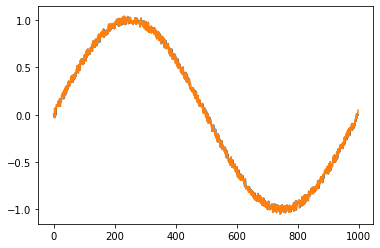

In [28]:
# 데이터셋

import numpy as np
import dezero
import matplotlib.pyplot as plt

train_set = dezero.datasets.SinCurve(train=True)
print(len(train_set))
print(train_set[0])
print(train_set[1])
print(train_set[2])

# 그래프 그리기
xs = [example[0] for example in train_set]
ts = [example[1] for example in train_set]
plt.plot(np.arange(len(xs)), xs, label='xs')
plt.plot(np.arange(len(ts)), ts, label='ts')
plt.show()

In [29]:
# 학습

# 하이퍼 파라미터 설정
max_epoch = 100
hidden_size = 100
bptt_length = 30 # BPTT 길이
train_set = dezero.datasets.SinCurve(train=True)
seqlen = len(train_set)

model = SimpleRNN(hidden_size, 1)
optimizer = dezero.optimizers.Adam().setup(model)

# 학습 시작
for epoch in range(max_epoch):
    model.reset_state()
    loss, count = 0, 0
    
    for x, t in train_set:
        x = x.reshape(1, 1) # 1. 형상을 (1, 1)로 변환
        y = model(x)
        loss += F.mean_squared_error(y, t)
        count += 1
        
        # 2. Truncated BPTT의 타이밍 조절
        if count % bptt_length == 0 or count == seqlen:
            model.cleargrads()
            loss.backward()
            loss.unchain_backward() # 3. 연결 끊기
            optimizer.update()
            
    avg_loss = float(loss.data) / count
    print('| epoch %d | loss %f' % (epoch + 1, avg_loss))

| epoch 1 | loss 0.125173
| epoch 2 | loss 0.118813
| epoch 3 | loss 0.017377
| epoch 4 | loss 0.006669
| epoch 5 | loss 0.002519
| epoch 6 | loss 0.002795
| epoch 7 | loss 0.002077
| epoch 8 | loss 0.002347
| epoch 9 | loss 0.002393
| epoch 10 | loss 0.002865
| epoch 11 | loss 0.004234
| epoch 12 | loss 0.006251
| epoch 13 | loss 0.006812
| epoch 14 | loss 0.005446
| epoch 15 | loss 0.004635
| epoch 16 | loss 0.004960
| epoch 17 | loss 0.005876
| epoch 18 | loss 0.006557
| epoch 19 | loss 0.006329
| epoch 20 | loss 0.005536
| epoch 21 | loss 0.004987
| epoch 22 | loss 0.004933
| epoch 23 | loss 0.005197
| epoch 24 | loss 0.005491
| epoch 25 | loss 0.005557
| epoch 26 | loss 0.005341
| epoch 27 | loss 0.005017
| epoch 28 | loss 0.004787
| epoch 29 | loss 0.004721
| epoch 30 | loss 0.004775
| epoch 31 | loss 0.004862
| epoch 32 | loss 0.004895
| epoch 33 | loss 0.004833
| epoch 34 | loss 0.004692
| epoch 35 | loss 0.004521
| epoch 36 | loss 0.004363
| epoch 37 | loss 0.004269
| epoch 38

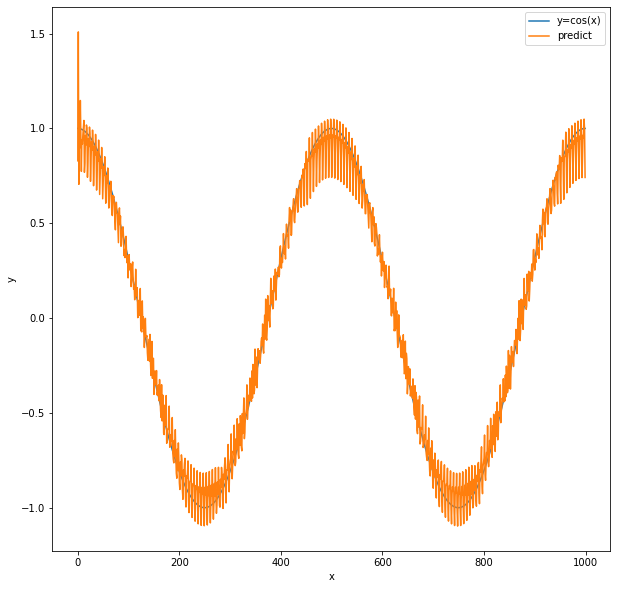

In [33]:
# 예측

import matplotlib.pyplot as plt

xs = np.cos(np.linspace(0, 4 * np.pi, 1000))
model.reset_state() # 모델 재설정
pred_list = []

with dezero.no_grad():
    for x in xs:
        x = np.array(x).reshape(1, 1)
        y = model(x)
        pred_list.append(float(y.data))
        
plt.figure(figsize=(10,10))
plt.plot(np.arange(len(xs)), xs, label='y=cos(x)')
plt.plot(np.arange(len(xs)), pred_list, label='predict')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

# 60단계 LSTM과 데이터 로더

시계열 데이터를 미니배치로 모아 학습하기 위한 전용 데이터 로더 구현  
  
시계열 데이터를 미니배치로 처리하려면 데이터를 뽑는 시작 위치를 배치별로 다르게 지정해야 함  
ex)  
데이터 1000개개로 구성된 시계열 데이터를 두 개의 미니배치로 만드는 경우  
첫 번째 샘플 데이터는 시계열 데이터의 시작(0 번째)부터,  
두 번째 샘플 데이터는 500번째 데이터부터 꺼냄  

In [1]:
from dezero import DataLoader
import dezero

class SeqDataLoader(DataLoader):
    def __init__(self, dataset ,batch_size, gpu=False):
        super().__init__(dataset=dataset, batch_size=batch_size, shuffle=False, 
                         gpu=gpu) # 시계열 데이터는 순서가 바뀌면 안되므로 shuffle=False
    
    def __next__(self): # 미니배치 데이터 가져오기
        if self.iteration >= self.max_iter:
            self.reset()
            raise StopIteration
            
        jump = self.data_size // self.batch_size
        batch_index = [(i * jump + self.iteration) % self.data_size for i in range(self.batch_size)]
        batch = [self.dataset[i] for i in batch_index]
        
        xp = cuda.cupy if self.gpu else np
        x = xp.array([example[0] for example in batch])
        t = xp.array([example[1] for example in batch])
        
        self.iteration += 1
        return x, t

In [3]:
import numpy as np

train_set = dezero.datasets.SinCurve(train=True)
dataloader = SeqDataLoader(train_set, batch_size=3)
x, t = next(dataloader)
print(x)
print('-----------------')
print(t)

[[-0.01388952]
 [ 0.83449744]
 [-0.81770762]]
-----------------
[[-0.01474094]
 [ 0.85185938]
 [-0.86606463]]


__RNN 계층을 대신할 LSTM 계층 구현__  
  
<img src='./img/5/LSTM_1.png' width=500>  
  
LSTM에서 수행되는 계산 식  
  
$f_t=\sigma(x_tW_x^{(f)}+h_{t-1}W_h^{(f)}+b^{(f)})$  
$i_t=\sigma(x_tW_x^{(i)}+h_{t-1}W_h^{(i)}+b^{(i)})$  
$o_t=\sigma(x_tW_x^{(o)}+h_{t-1}W_h^{(o)}+b^{(o)})$  
$u_t=tanh(x_tW_x^{(u)}+h_{t-1}W_h^{(u)}+b^{(u)})$  
$c_t=f_t\odot c_{t-1}+i_t\odot u_t$  
$h_t=o_t\odot tanh(c_t)$  
  
LSTM에서는 은닉 상태 h 외에도 기억 셀 c를 사용함  
여기서 $\odot$(Hadamard product, 아다마르 곱)은 같은 크기의 두 행렬의 각 성분을 곱하는 연산을 의미함  


__DeZero로 구현__  

~~~python
class LSTM(Layer):
    def __init__(self, hidden_size, in_size=None):
        super().__init__()
        
        H, I = hidden_size, in_size
        self.x2f = Linear(H, in_size=I)
        self.x2i = Linear(H, in_size=I)
        self.x2o = Linear(H, in_size=I)
        self.x2u = Linear(H, in_size=I)
        self.h2f = Linear(H, in_size=H, nobias=True)
        self.h2i = Linear(H, in_size=H, nobias=True)
        self.h2o = Linear(H, in_size=H, nobias=True)
        self.h2u = Linear(H, in_size=H, nobias=True)
        self.reset_state()
        
    def reset_state(self):
        self.h = None
        self.c = None
        
    def forward(self, x):
        if self.h is None:
            f = F.sigmoid(self.x2f(x))
            i = F.sigmoid(self.x2i(x))
            o = F.sigmoid(self.x2o(x))
            u = F.tanh(self.x2u(x))
            
        else:
            f = F.sigmoid(self.x2f(x) + self.h2f(self.h))
            i = F.sigmoid(self.x2i(x) + self.h2i(self.h))
            o = F.sigmoid(self.x2o(x) + self.h2o(self.h))
            u = F.tanh(self.x2u(x) + self.h2u(self.h))
            
        if self.c is None:
            c_new = (i * u)
        else:
            c_new = (f * self.c) + (i * u)
            h_new = o * F.tanh(c_new)
            
            self.h, self.c = h_new, c_new
            return h_new
~~~

__사인파 데이터 학습__

In [4]:
import numpy as np
import dezero
from dezero import Model
from dezero import SeqDataLoader
import dezero.functions as F
import dezero.layers as L

max_epoch = 100
batch_size = 30
hidden_size = 100
bptt_length = 30

train_set = dezero.datasets.SinCurve(train=True)
# 1. 시계열용 데이터 로더 사용
dataloader = SeqDataLoader(train_set, batch_size=batch_size)
seqlen = len(train_set)

class BetterRNN(Model):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.rnn = L.LSTM(hidden_size) # 2. LSTM 사용
        self.fc = L.Linear(out_size)
        
    def reset_state(self):
        self.rnn.reset_state()
        
    def forward(self, x):
        y = self.rnn(x)
        y = self.fc(y)
        return y
    
model = BetterRNN(hidden_size, 1)
optimizer = dezero.optimizers.Adam().setup(model)

for epoch in range(max_epoch):
    model.reset_state()
    loss, count = 0, 0
    
    for x, t in dataloader:
        y = model(x)
        loss += F.mean_squared_error(y, t)
        count += 1
        if count % bptt_length == 0 or count == seqlen:
            # dezero.utils.plot_dot_graph(loss) # 계산 그래프 그리기
            model.cleargrads()
            loss.backward()
            loss.unchain_backward()
            optimizer.update()
    avg_loss = float(loss.data) / count
    print('| epoch %d | loss %f' % (epoch + 1, avg_loss))

| epoch 1 | loss 0.460372
| epoch 2 | loss 0.359698
| epoch 3 | loss 0.273510
| epoch 4 | loss 0.201713
| epoch 5 | loss 0.144308
| epoch 6 | loss 0.101000
| epoch 7 | loss 0.071076
| epoch 8 | loss 0.053233
| epoch 9 | loss 0.045384
| epoch 10 | loss 0.044751
| epoch 11 | loss 0.048395
| epoch 12 | loss 0.053705
| epoch 13 | loss 0.058554
| epoch 14 | loss 0.061439
| epoch 15 | loss 0.061666
| epoch 16 | loss 0.059318
| epoch 17 | loss 0.055011
| epoch 18 | loss 0.049581
| epoch 19 | loss 0.043840
| epoch 20 | loss 0.038427
| epoch 21 | loss 0.033757
| epoch 22 | loss 0.030021
| epoch 23 | loss 0.027236
| epoch 24 | loss 0.025296
| epoch 25 | loss 0.024030
| epoch 26 | loss 0.023249
| epoch 27 | loss 0.022776
| epoch 28 | loss 0.022470
| epoch 29 | loss 0.022224
| epoch 30 | loss 0.021973
| epoch 31 | loss 0.021682
| epoch 32 | loss 0.021339
| epoch 33 | loss 0.020947
| epoch 34 | loss 0.020512
| epoch 35 | loss 0.020042
| epoch 36 | loss 0.019543
| epoch 37 | loss 0.019019
| epoch 38

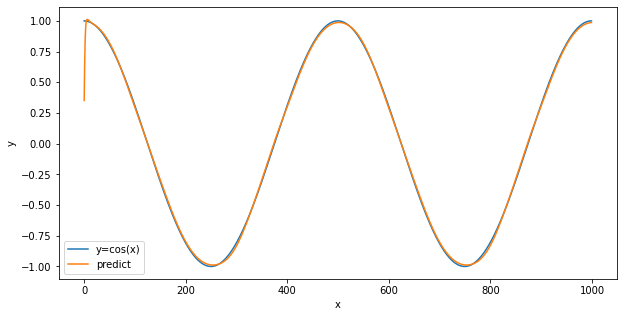

In [6]:
# 예측

import matplotlib.pyplot as plt

xs = np.cos(np.linspace(0, 4 * np.pi, 1000))
model.reset_state()
pred_list = []

with dezero.no_grad():
    for x in xs:
        x = np.array(x).reshape(1, 1)
        y = model(x)
        pred_list.append(float(y.data))
        
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(xs)), xs, label='y=cos(x)')
plt.plot(np.arange(len(xs)), pred_list, label='predict')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()